In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
sns.set_context('poster')

from sklearn.preprocessing import  StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.externals import joblib

# Importing from my own modules
import sys
sys.path.append('../financial_forecasting/')
from utils import load_data, wMSE
from preprocessing import transform_to_embedding_vec

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Input, Reshape, Concatenate
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

/Users/km1308/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load preprocessed data

In [3]:
X_train = pd.read_csv('../data/preprocessed/train.csv')
X_val = pd.read_csv('../data/preprocessed/validation.csv')
X_test = pd.read_csv('../data/preprocessed/test.csv')

weights_train = pd.read_csv('../data/preprocessed/train_weights.csv', squeeze=True)
weights_val = pd.read_csv('../data/preprocessed/validation_weights.csv', squeeze=True)

y_train = pd.read_csv('../data/preprocessed/train_target.csv', squeeze=True)
y_val = pd.read_csv('../data/preprocessed/validation_target.csv', squeeze=True)

# Re-scale the data

In [5]:
# One hot encoding for Market variable, drop Day variable
X_train = pd.get_dummies(X_train, drop_first=True, columns=['Market'], prefix='Market')
X_train.drop(labels=['Day'], axis=1, inplace=True)

X_val = pd.get_dummies(X_val, drop_first=True, columns=['Market'], prefix='Market')
X_val.drop(labels=['Day'], axis=1, inplace=True)

X_test = pd.get_dummies(X_test, drop_first=True, columns=['Market'], prefix='Market')
X_test.drop(labels=['Day'], axis=1, inplace=True)

In [6]:
feats_to_scale = ['x0', 'x1', 'x2', 'x3A', 'x3B', 'x3C', 'x3D','x3E', 'x4', 'x5', 'x6', 
'x0_log10', 'x1_log10', 'x2_log10','x3A_log10', 'x3B_log10','x3C_log10', 'x3D_log10', 'x3E_log10', 'x4_log10',
'x5_log10', 'x6_log10', 'Market_mean_encoded', 'Day_mean_encoded', 'Stock_mean_encoded',
'x0_log10_diff', 'x1_log10_diff', 'x2_log10_diff','x3A_log10_diff', 'x3B_log10_diff', 
'x3C_log10_diff', 'x3D_log10_diff', 'x3E_log10_diff', 'x4_log10_diff', 'x5_log10_diff',
'x6_log10_diff']

feats_remaining = list(set(X_train.columns) - set(feats_to_scale))

In [7]:
scaler = RobustScaler()

In [8]:
scaler.fit(X_train.loc[:, feats_to_scale])

df = pd.DataFrame(scaler.transform(X_train.loc[:, feats_to_scale]), columns=feats_to_scale, index=X_train.index)
X_train = pd.concat([df, X_train[feats_remaining]],axis=1)

df = pd.DataFrame(scaler.transform(X_val.loc[:, feats_to_scale]), columns=feats_to_scale, index=X_val.index)
X_val = pd.concat([df, X_val[feats_remaining]],axis=1)

df = pd.DataFrame(scaler.transform(X_test.loc[:, feats_to_scale]), columns=feats_to_scale, index=X_test.index)
X_test = pd.concat([df, X_test[feats_remaining]],axis=1)

# Train entity embeddings

In [14]:
embedding_dim = 100

In [15]:
input_stock = Input(shape=(1,))
output_stock = Embedding(input_dim=3023, output_dim=embedding_dim, input_length=1, name='stock_embedding')(input_stock)
output_stock = Reshape(target_shape=(embedding_dim,), name='stock_embedding_reshaped')(output_stock)

input_features = Input(shape=(64,), name='numeric_features')

input_model = [output_stock, input_features]

output_model = Concatenate()(input_model)
output_model = Dense(1000, kernel_initializer="uniform")(output_model)
output_model = BatchNormalization()(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(500, kernel_initializer="uniform")(output_model)
output_model = Activation('relu')(output_model)
output_model = Dense(1)(output_model)

In [16]:
model = Model([input_stock, input_features], output_model)
model.compile(optimizer='adam', loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
stock_embedding (Embedding)     (None, 1, 100)       302300      input_2[0][0]                    
__________________________________________________________________________________________________
stock_embedding_reshaped (Resha (None, 100)          0           stock_embedding[0][0]            
__________________________________________________________________________________________________
numeric_features (InputLayer)   (None, 64)           0                                            
__________________________________________________________________________________________________
concatenat

In [17]:
inputs = [X_train.Stock.values, X_train.values]

In [18]:
model.fit(inputs, y_train, batch_size=32, epochs=5, sample_weight=weights_train.values)

Epoch 1/5
623817/623817 [==============================] - 189s 303us/step - loss: 0.1986
Epoch 2/5
623817/623817 [==============================] - 187s 299us/step - loss: 8.1103e-06
Epoch 3/5
623817/623817 [==============================] - 187s 300us/step - loss: 1.8718e-06
Epoch 4/5
623817/623817 [==============================] - 192s 308us/step - loss: 1.8563e-06
Epoch 5/5
623817/623817 [==============================] - 199s 319us/step - loss: 1.8465e-06


In [ ]:
# Evaluate model
preds = model.predict([X_train.Stock.values, X_train.values])
print(wMSE(preds.flatten(), y_train, weights_train))

preds = model.predict([X_val.Stock.values, X_val.values])
print(wMSE(preds.flatten(), y_val, weights_val))

1.612928835723912e-06


In [ ]:
# Extract embeddings matrix
embedding_matrix = model.layers[1].get_weights()[0]

In [ ]:
# Save embeddings
file = '../data/embeddings_2.pkl'
joblib.dump(embedding_matrix, filename=file)

# Visualise embeddings

In [17]:
df_embeddings_train = transform_to_embedding_vec(X_train.Stock, embedding_matrix)
df_embeddings_val = transform_to_embedding_vec(X_val.Stock, embedding_matrix)
df_embeddings_test = transform_to_embedding_vec(X_test.Stock, embedding_matrix)

In [24]:
X_tsne = TSNE(n_components=2).fit_transform(df_embeddings_train.head(5000))

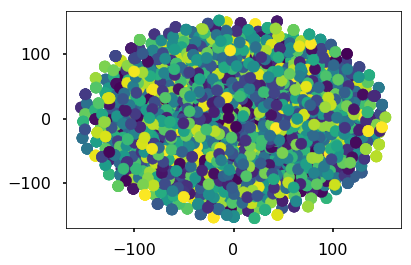

In [25]:
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=X_train.Stock[:5000] )

Lack of structure suggests that the embeddings may not capture any useful information for this task. This could also be due to the poor performance of the neural network used to train the embeddings in the first place. Future work could involve trying different neural network parameters and architecture. The size of the embedding dimension could also be tuned.

Despite the lack of tuning. Using entity embeddings improves the model performance of gradient boosted trees. See next notebook.